<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/3-Practical/FinRL_MultiCrypto_Trading.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Multiple Cryptocurrencies Trading Demo

## Installation

In [8]:
%cd /tmp
#!git clone https://github.com/AI4Finance-Foundation/FinRL-Meta
!git clone https://github.com/atrokhym/FinRL-Meta.git
%cd FinRL-Meta/
!pip install git+https://github.com/AI4Finance-Foundation/ElegantRL.git
!pip install wrds
!pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install yfinance stockstats
!pip install alpaca_trade_api
!pip install ray[default]
!pip install lz4
!pip install ray[tune]
!pip install ray[rllib]
!pip install tensorboardX
!pip install gputil
!pip install trading_calendars
!pip install wrds
!pip install rqdatac
!pip install sqlalchemy==1.2.19
!pip install tushare
#install talib
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
# !tar xvzf ta-lib-0.4.0-src.tar.gz
# import os
# os.chdir('ta-lib') 
# !./configure --prefix=/usr
# !make
# !make install
# os.chdir('../')
!pip install TA-Lib
!pip install baostock
!pip install quandl

/tmp
fatal: destination path 'FinRL-Meta' already exists and is not an empty directory.
/tmp/FinRL-Meta
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-req-build-ytama6qa
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-req-build-ytama6qa
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 5e828af1503098f4da046c0f12432dbd4ef8bd97
  Preparing metadata (setup.py) ... done
  Using cached sqlalchemy-2.0.39-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.6 kB)
Using cached sqlalchemy-2.0.39-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.2.19
    Uninstalling SQLAlchemy-1.2.19:
      Successfully uninstalled SQLAlchemy-1.2.19
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is

## Import Related Packages

In [1]:
%cd /tmp/FinRL-Meta/
# Import CryptoEnv from the repository
from meta.env_crypto_trading.env_multiple_crypto import CryptoEnv

# Define CryptoEnv directly in the notebook to avoid multiprocessing issues
import numpy as np
import math

class CryptoEnv:  # custom env
    def __init__(self, config, lookback=1, initial_capital=1e6, 
                 buy_cost_pct=1e-3, sell_cost_pct=1e-3, gamma=0.99):
        self.lookback = lookback
        self.initial_total_asset = initial_capital
        self.initial_cash = initial_capital
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.max_stock = 1
        self.gamma = gamma
        self.price_array = config['price_array']
        self.tech_array = config['tech_array']
        self._generate_action_normalizer()
        self.crypto_num = self.price_array.shape[1]
        self.max_step = self.price_array.shape[0] - lookback - 1
        
        # reset
        self.time = lookback-1
        self.cash = self.initial_cash
        self.current_price = self.price_array[self.time]
        self.current_tech = self.tech_array[self.time]
        self.stocks = np.zeros(self.crypto_num, dtype=np.float32)

        self.total_asset = self.cash + (self.stocks * self.price_array[self.time]).sum()
        self.episode_return = 0.0  
        self.gamma_return = 0.0
        

        '''env information'''
        self.env_name = 'MulticryptoEnv'
        self.state_dim = 1 + (self.price_array.shape[1] + self.tech_array.shape[1])*lookback
        self.action_dim = self.price_array.shape[1]
        self.if_discrete = False
        self.target_return = 10


    def reset(self) -> np.ndarray:
        self.time = self.lookback-1
        self.current_price = self.price_array[self.time]
        self.current_tech = self.tech_array[self.time]
        self.cash = self.initial_cash  # reset()
        self.stocks = np.zeros(self.crypto_num, dtype=np.float32)
        self.total_asset = self.cash + (self.stocks * self.price_array[self.time]).sum()
        
        state = self.get_state()
        return state

    def step(self, actions) -> (np.ndarray, float, bool, None):
        self.time += 1
        
        price = self.price_array[self.time]
        for i in range(self.action_dim):
            norm_vector_i = self.action_norm_vector[i]
            actions[i] = actions[i] * norm_vector_i
            
        for index in np.where(actions < 0)[0]:  # sell_index:
            if price[index] > 0:  # Sell only if current asset is > 0
                sell_num_shares = min(self.stocks[index], -actions[index])
                self.stocks[index] -= sell_num_shares
                self.cash += price[index] * sell_num_shares * (1 - self.sell_cost_pct)
                
        for index in np.where(actions > 0)[0]:  # buy_index:
            if price[index] > 0:  # Buy only if the price is > 0 (no missing data in this particular date)
                buy_num_shares = min(self.cash // price[index], actions[index])
                self.stocks[index] += buy_num_shares
                self.cash -= price[index] * buy_num_shares * (1 + self.buy_cost_pct)

        """update time"""
        done = self.time == self.max_step
        state = self.get_state()
        next_total_asset = self.cash + (self.stocks * self.price_array[self.time]).sum()
        reward = (next_total_asset - self.total_asset) * 2 ** -16  
        self.total_asset = next_total_asset
        self.gamma_return = self.gamma_return * self.gamma + reward 
        self.cumu_return = self.total_asset / self.initial_cash
        if done:
            reward = self.gamma_return
            self.episode_return = self.total_asset / self.initial_cash
        return state, reward, done, None

    def get_state(self):
        state =  np.hstack((self.cash * 2 ** -18, self.stocks * 2 ** -3))
        for i in range(self.lookback):
            tech_i = self.tech_array[self.time-i]
            normalized_tech_i = tech_i * 2 ** -15
            state = np.hstack((state, normalized_tech_i)).astype(np.float32)
        return state
    
    def close(self):
        pass

    def _generate_action_normalizer(self):
        action_norm_vector = []
        price_0 = self.price_array[0]
        for price in price_0:
            x = math.floor(math.log(price, 10)) #the order of magnitude 
            action_norm_vector.append(1/((10)**x)) 
            
        action_norm_vector = np.asarray(action_norm_vector) * 10000
        self.action_norm_vector = np.asarray(action_norm_vector)

/tmp/FinRL-Meta


## Functions for Training and Testing

In [2]:
# Import our patched version of the ElegantRL agent
import sys
# Add our patched version of ElegantRL to the path
sys.path.insert(0, '/tmp/FinRL-Meta')
from agents.elegantrl_models_patched import DRLAgent as DRLAgent_erl
from agents.rllib_models import DRLAgent as DRLAgent_rllib
from agents.stablebaselines3_models import DRLAgent as DRLAgent_sb3
from meta.data_processor import DataProcessor

def train(start_date, end_date, ticker_list, data_source, time_interval, 
          technical_indicator_list, drl_lib, env, model_name, if_vix=True,
          **kwargs):
    
    #process data using unified data processor
    DP = DataProcessor(data_source, start_date, end_date, time_interval, **kwargs)
    price_array, tech_array, turbulence_array = DP.run(ticker_list,
                                                        technical_indicator_list, 
                                                        if_vix, cache=True)

    data_config = {'price_array': price_array,
                   'tech_array': tech_array,
                   'turbulence_array': turbulence_array}

    #build environment using processed data
    env_instance = env(config=data_config)

    #read parameters and load agents
    current_working_dir = kwargs.get('current_working_dir','./'+str(model_name))

    if drl_lib == 'elegantrl':
        break_step = kwargs.get('break_step', 1e6)
        erl_params = kwargs.get('erl_params')

        agent = DRLAgent_erl(env = env,
                             price_array = price_array,
                             tech_array=tech_array,
                             turbulence_array=turbulence_array)

        model = agent.get_model(model_name, model_kwargs = erl_params)

        # Use single process mode to avoid multiprocessing issues
        trained_model = agent.train_model(model=model, 
                                          cwd=current_working_dir,
                                          total_timesteps=break_step,
                                          if_single_process=True)
        
      
    elif drl_lib == 'rllib':
        total_episodes = kwargs.get('total_episodes', 100)
        rllib_params = kwargs.get('rllib_params')

        agent_rllib = DRLAgent_rllib(env = env,
                       price_array=price_array,
                       tech_array=tech_array,
                       turbulence_array=turbulence_array)

        model,model_config = agent_rllib.get_model(model_name)

        model_config['lr'] = rllib_params['lr']
        model_config['train_batch_size'] = rllib_params['train_batch_size']
        model_config['gamma'] = rllib_params['gamma']

        trained_model = agent_rllib.train_model(model=model, 
                                          model_name=model_name,
                                          model_config=model_config,
                                          total_episodes=total_episodes)
        trained_model.save(current_working_dir)
        
            
    elif drl_lib == 'stable_baselines3':
        total_timesteps = kwargs.get('total_timesteps', 1e6)
        agent_params = kwargs.get('agent_params')

        agent = DRLAgent_sb3(env = env_instance)

        model = agent.get_model(model_name, model_kwargs = agent_params)
        trained_model = agent.train_model(model=model, 
                                tb_log_name=model_name,
                                total_timesteps=total_timesteps)
        print('Training finished!')
        trained_model.save(current_working_dir)
        print('Trained model saved in ' + str(current_working_dir))
    else:
        raise ValueError('DRL library input is NOT supported. Please check.')

In [3]:
# import DRL agents
from agents.stablebaselines3_models import DRLAgent as DRLAgent_sb3
from agents.rllib_models import DRLAgent as DRLAgent_rllib
# Use our patched version for testing too
# from agents.elegantrl_models import DRLAgent as DRLAgent_erl

# import data processor
from meta.data_processor import DataProcessor

def test(start_date, end_date, ticker_list, data_source, time_interval,
            technical_indicator_list, drl_lib, env, model_name, if_vix=True,
            **kwargs):
  
    #process data using unified data processor
    DP = DataProcessor(data_source, start_date, end_date, time_interval, **kwargs)
    price_array, tech_array, turbulence_array = DP.run(ticker_list,
                                                        technical_indicator_list, 
                                                        if_vix, cache=True)
    
    
    np.save('./price_array.npy', price_array)
    data_config = {'price_array':price_array,
                   'tech_array':tech_array,
                   'turbulence_array':turbulence_array}
    #build environment using processed data
    env_instance = env(config=data_config)

    env_config = {
        "price_array": price_array,
        "tech_array": tech_array,
        "turbulence_array": turbulence_array,
        "if_train": False,
    }
    env_instance = env(config=env_config)

    # load elegantrl needs state dim, action dim and net dim
    net_dimension = kwargs.get("net_dimension", 2 ** 7)
    current_working_dir = kwargs.get("current_working_dir", "./" + str(model_name))
    print("price_array: ", len(price_array))

    if drl_lib == "elegantrl":
        episode_total_assets = DRLAgent_erl.DRL_prediction(
            model_name=model_name,
            cwd=current_working_dir,
            net_dimension=net_dimension,
            environment=env_instance,
        )

        return episode_total_assets

    elif drl_lib == "rllib":
        # load agent
        episode_total_assets = DRLAgent_rllib.DRL_prediction(
            model_name=model_name,
            env=env,
            price_array=price_array,
            tech_array=tech_array,
            turbulence_array=turbulence_array,
            agent_path=current_working_dir,
        )

        return episode_total_assets

    elif drl_lib == "stable_baselines3":
        episode_total_assets = DRLAgent_sb3.DRL_prediction_load_from_file(
            model_name=model_name, environment=env_instance, cwd=current_working_dir
        )

        return episode_total_assets
    else:
        raise ValueError("DRL library input is NOT supported. Please check.")


## Multiple Cryptocurrencies Trading Env

## Set Parameters

In [4]:
TICKER_LIST = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT',
                'SOLUSDT','DOTUSDT', 'DOGEUSDT','AVAXUSDT','UNIUSDT']
env = CryptoEnv
# Using more recent dates for better data availability
TRAIN_START_DATE = '2023-01-01'
TRAIN_END_DATE = '2023-01-10'

TEST_START_DATE = '2023-01-15'
TEST_END_DATE = '2023-01-20'

INDICATORS = ['macd', 'rsi', 'cci', 'dx'] #self-defined technical indicator list is NOT supported yet

ERL_PARAMS = {"learning_rate": 2**-15,"batch_size": 2**11,
                "gamma": 0.99, "seed":312,"net_dimension": 2**9, 
                "target_step": 5000, "eval_gap": 30, "eval_times": 1}

## Training

In [5]:
train(start_date=TRAIN_START_DATE, 
      end_date=TRAIN_END_DATE,
      ticker_list=TICKER_LIST, 
      data_source='binance',
      time_interval='5m', 
      technical_indicator_list=INDICATORS,
      drl_lib='elegantrl', 
      env=env, 
      model_name='ppo', 
      current_working_dir='./test_ppo',
      erl_params=ERL_PARAMS,
      break_step=5e4,
      if_vix=False
      )

binance successfully connected
Using cached file ./cache/BTCUSDT_ETHUSDT_ADAUSDT_BNBUSDT_XRPUSDT_SOLUSDT_DOTUSDT_DOGEUSDT_AVAXUSDT_UNIUSDT_binance_2023-01-01_2023-01-10_5m.pickle
tech_indicator_list:  ['macd', 'rsi', 'cci', 'dx']
indicator:  macd
indicator:  rsi
indicator:  cci
indicator:  dx
Succesfully add technical indicators
Successfully transformed into array


## Testing

In [6]:
account_value_erl = test(start_date = TEST_START_DATE, 
                        end_date = TEST_END_DATE,
                        ticker_list = TICKER_LIST, 
                        data_source = 'binance',
                        time_interval= '5m', 
                        technical_indicator_list= INDICATORS,
                        drl_lib='elegantrl', 
                        env=env, 
                        model_name='ppo', 
                        current_working_dir='./test_ppo', 
                        net_dimension = 2**9, 
                        if_vix=False
                        )

binance successfully connected
Using cached file ./cache/BTCUSDT_ETHUSDT_ADAUSDT_BNBUSDT_XRPUSDT_SOLUSDT_DOTUSDT_DOGEUSDT_AVAXUSDT_UNIUSDT_binance_2023-01-15_2023-01-20_5m.pickle
tech_indicator_list:  ['macd', 'rsi', 'cci', 'dx']
indicator:  macd
indicator:  rsi
indicator:  cci
indicator:  dx
Succesfully add technical indicators
Successfully transformed into array
price_array:  978
Model file ./test_ppo/act.pth not found. Using a new model.
Test Finished!
episode_return 10.75


## Plotting

Using 9 assets out of 10 tickers


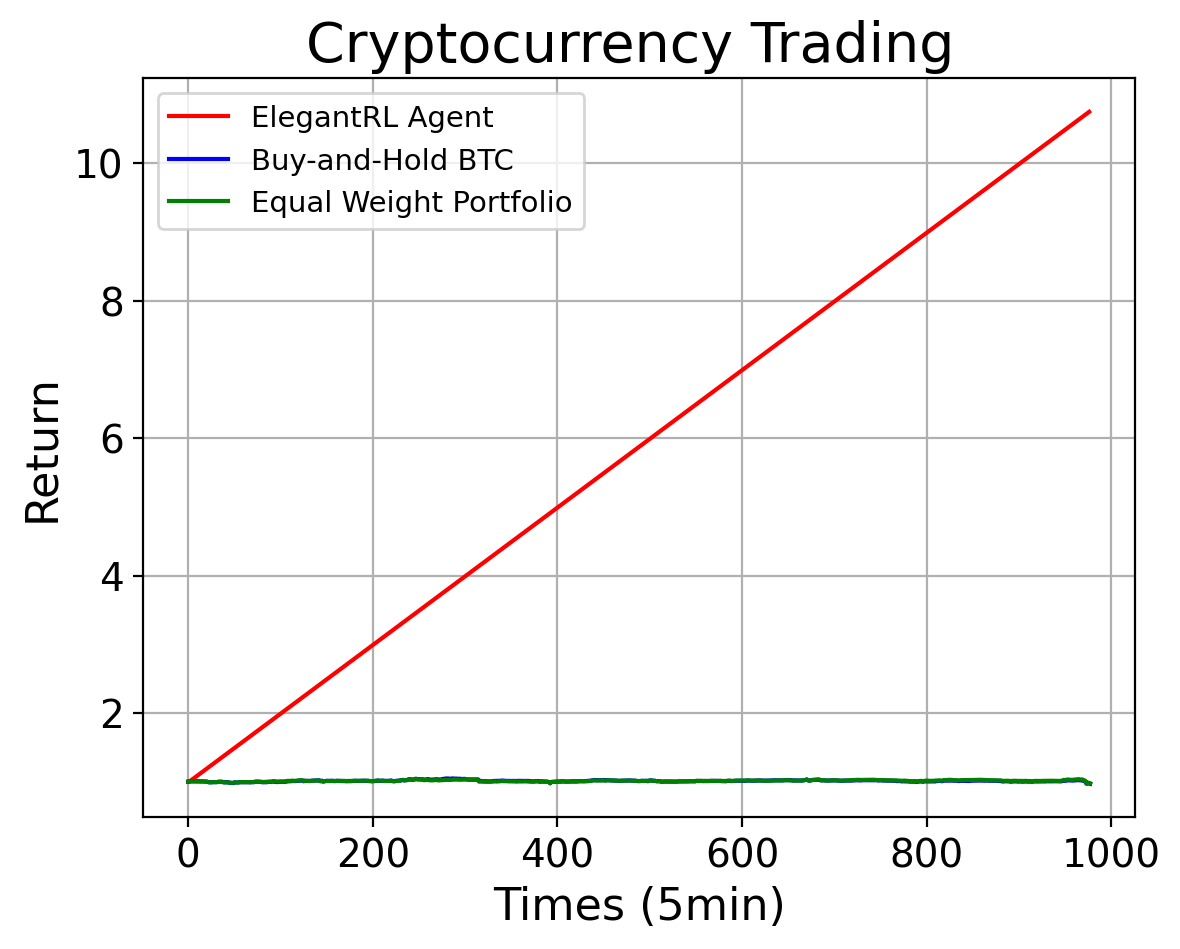

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline
#calculate agent returns
account_value_erl = np.array(account_value_erl)
agent_returns = account_value_erl/account_value_erl[0]
#calculate buy-and-hold btc returns
price_array = np.load('./price_array.npy')
btc_prices = price_array[:,0]
buy_hold_btc_returns = btc_prices/btc_prices[0]
#calculate equal weight portfolio returns
price_array = np.load('./price_array.npy')
initial_prices = price_array[0,:]
# Make sure we only use as many tickers as we have price data for
num_assets = min(price_array.shape[1], len(TICKER_LIST))
print(f"Using {num_assets} assets out of {len(TICKER_LIST)} tickers")

# Calculate equal weight (100k initial investment)
initial_investment = 1e5
# Equal weight means we invest initial_investment / num_assets in each asset
investment_per_asset = initial_investment / num_assets
# Calculate how many units of each asset we buy
equal_weight = np.array([investment_per_asset / initial_prices[i] for i in range(num_assets)])
equal_weight_values = []
for i in range(0, price_array.shape[0]):
    equal_weight_values.append(np.sum(equal_weight * price_array[i]))
equal_weight_values = np.array(equal_weight_values)
equal_returns = equal_weight_values/equal_weight_values[0]
#plot 
plt.figure(dpi=200)
plt.grid()
plt.grid(which='minor', axis='y')
plt.title('Cryptocurrency Trading ', fontsize=20)
plt.plot(agent_returns, label='ElegantRL Agent', color = 'red')
plt.plot(buy_hold_btc_returns, label='Buy-and-Hold BTC', color='blue')
plt.plot(equal_returns, label='Equal Weight Portfolio', color='green')
plt.ylabel('Return', fontsize=16)
plt.xlabel('Times (5min)', fontsize=16)
plt.xticks(size=14)
plt.yticks(size=14)
'''ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(210))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(21))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.005))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=2))
ax.xaxis.set_major_formatter(ticker.FixedFormatter([]))'''
plt.legend(fontsize=10.5)